In [158]:
import glob

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import metpy
import cartopy.feature as cfeature

from tqdm.notebook import tqdm

EPA data downloaded from here: [https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw)

In [3]:
xr.set_options(keep_attrs=True)

In [4]:
dates = pd.date_range(start='2021-01-01', end='2022-01-01', freq='1d', inclusive="left", tz='GMT').values
files = {}
for i in dates:
    date = f'{pd.to_datetime(i).dayofyear:03}'
    files[date] = sorted(glob.glob(f'/Volumes/Shores/GOES/AODC/averages/2021/{date}/*.nc'))

In [5]:
with xr.open_dataset(files['001'][14]) as aod:
    aod.load()

In [6]:
geo = aod.metpy.parse_cf('AOD').metpy.cartopy_crs
plate = ccrs.PlateCarree()
equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)

In [7]:
geo

<Derived Projected CRS: +proj=geos +a=6378137.0 +b=6356752.31414 +rf=298.2 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: unknown
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
plate

<Derived Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
equal_area

<Derived Projected CRS: +proj=aea +ellps=WGS84 +lon_0=-98.5795 +lat_0=39.8 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Hourly

In [21]:
df = pd.read_csv('/Users/kyle/Downloads/hourly_88101_2021.csv', 
                 parse_dates=[['Date GMT', 'Time GMT']],
                 dtype={'Qualifier': 'str'})

In [23]:
df.Datum.unique()

array(['NAD83', 'WGS84'], dtype=object)

In [6]:
df = pd.read_csv('/Users/kyle/Downloads/hourly_88101_2021.csv', 
                 parse_dates=[['Date GMT', 'Time GMT']],
                 dtype={'Qualifier': 'str'})

df.rename(columns = {
    'Date GMT_Time GMT':'time', 
    'Sample Measurement': 'value',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace = True)

keep = ['time', 'longitude', 'latitude', 'value']
df.drop(columns=df.columns.difference(keep),inplace=True)

df = df.loc[df.value >= 0]

In [7]:
df

time   latitude   longitude  value
0       2021-12-07 21:00:00  33.991494  -85.992647    5.0
1       2021-12-07 22:00:00  33.991494  -85.992647    3.0
2       2021-12-07 23:00:00  33.991494  -85.992647    7.0
3       2021-12-08 00:00:00  33.991494  -85.992647    5.0
4       2021-12-08 01:00:00  33.991494  -85.992647    6.0
...                     ...        ...         ...    ...
6212515 2022-01-01 03:00:00  32.633671 -115.504995   15.0
6212516 2022-01-01 04:00:00  32.633671 -115.504995   21.0
6212517 2022-01-01 05:00:00  32.633671 -115.504995   21.0
6212518 2022-01-01 06:00:00  32.633671 -115.504995   30.0
6212519 2022-01-01 07:00:00  32.633671 -115.504995   15.0

[6058794 rows x 4 columns]

In [8]:
transformed = geo.transform_points(src_crs=plate, x=df['longitude'], y=df['latitude'])
df['proj_longitude'] = transformed[:,0]
df['proj_latitude'] = transformed[:,1]

In [9]:
sat_h = aod.goes_imager_projection.perspective_point_height
minx, maxx = aod.x.min().item() * sat_h, aod.x.max().item() * sat_h
miny, maxy = aod.y.min().item() * sat_h, aod.y.max().item() * sat_h

In [10]:
# drop locations that are not observable by GOES-16
df = df[
    (df.proj_longitude >= minx) & 
    (df.proj_longitude <= maxx) & 
    (df.proj_latitude >= miny) & 
    (df.proj_latitude <= maxy)
]

In [11]:
df

time   latitude   longitude  value  proj_longitude  \
0       2021-12-07 21:00:00  33.991494  -85.992647    5.0   -9.724701e+05   
1       2021-12-07 22:00:00  33.991494  -85.992647    3.0   -9.724701e+05   
2       2021-12-07 23:00:00  33.991494  -85.992647    7.0   -9.724701e+05   
3       2021-12-08 00:00:00  33.991494  -85.992647    5.0   -9.724701e+05   
4       2021-12-08 01:00:00  33.991494  -85.992647    6.0   -9.724701e+05   
...                     ...        ...         ...    ...             ...   
6212515 2022-01-01 03:00:00  32.633671 -115.504995   15.0   -3.259868e+06   
6212516 2022-01-01 04:00:00  32.633671 -115.504995   21.0   -3.259868e+06   
6212517 2022-01-01 05:00:00  32.633671 -115.504995   21.0   -3.259868e+06   
6212518 2022-01-01 06:00:00  32.633671 -115.504995   30.0   -3.259868e+06   
6212519 2022-01-01 07:00:00  32.633671 -115.504995   15.0   -3.259868e+06   

         proj_latitude  
0         3.421877e+06  
1         3.421877e+06  
2         3.421877e+06  
3         3.421877e+06  
4         3.421877e+06  
...                ...  
6212515   3.205527e+06  
6212516   3.205527e+06  
6212517   3.205527e+06  
6212518   3.205527e+06  
6212519   3.205527e+06  

[5937793 rows x 6 columns]

In [12]:
# for locations that have more than one observation at the same time, average them
df = df.groupby(['longitude', 'latitude', 'time']).mean()
df.reset_index(inplace=True)

In [13]:
df

longitude   latitude                time  value  proj_longitude  \
0       -123.358720  39.398610 2021-02-05 03:00:00    6.0   -3.366348e+06   
1       -123.358720  39.398610 2021-02-05 04:00:00   18.0   -3.366348e+06   
2       -123.358720  39.398610 2021-02-05 05:00:00   12.0   -3.366348e+06   
3       -123.358720  39.398610 2021-02-05 06:00:00    7.0   -3.366348e+06   
4       -123.358720  39.398610 2021-02-05 07:00:00   21.0   -3.366348e+06   
...             ...        ...                 ...    ...             ...   
5634834  -68.016195  46.682299 2022-01-01 00:00:00    5.0    5.006529e+05   
5634835  -68.016195  46.682299 2022-01-01 01:00:00    5.0    5.006529e+05   
5634836  -68.016195  46.682299 2022-01-01 02:00:00    5.0    5.006529e+05   
5634837  -68.016195  46.682299 2022-01-01 03:00:00    4.0    5.006529e+05   
5634838  -68.016195  46.682299 2022-01-01 04:00:00    3.0    5.006529e+05   

         proj_latitude  
0         3.692566e+06  
1         3.692566e+06  
2         3.692566e+06  
3         3.692566e+06  
4         3.692566e+06  
...                ...  
5634834   4.348521e+06  
5634835   4.348521e+06  
5634836   4.348521e+06  
5634837   4.348521e+06  
5634838   4.348521e+06  

[5634839 rows x 6 columns]

In [14]:
empty = np.empty(df.shape[0])
empty[:] = np.nan
df['AOD'] = empty

In [15]:
df.set_index(['time', 'longitude', 'latitude'], inplace=True)
df.sort_index(inplace=True)

In [16]:
df

value  proj_longitude  \
time                longitude   latitude                           
2021-01-01 05:00:00 -87.401312  39.485987   17.9   -1.008125e+06   
                    -86.852500  40.431639   10.1   -9.493736e+05   
                    -86.738900  36.176382    6.2   -1.005700e+06   
                    -86.504762  39.159383   12.6   -9.416949e+05   
                    -86.214722  41.696660   35.5   -8.798007e+05   
...                                          ...             ...   
2022-01-01 07:00:00 -115.091437 36.214465    2.7   -3.083916e+06   
                    -115.078742 36.141875    3.6   -3.086338e+06   
                    -115.052942 36.048705    2.7   -3.088875e+06   
                    -114.835007 35.969848    0.7   -3.079365e+06   
                    -114.050347 36.815897    0.5   -2.995833e+06   

                                           proj_latitude  AOD  
time                longitude   latitude                       
2021-01-01 05:00:00 -87.401312  39.485987   3.850257e+06  NaN  
                    -86.852500  40.431639   3.920623e+06  NaN  
                    -86.738900  36.176382   3.597535e+06  NaN  
                    -86.504762  39.159383   3.827604e+06  NaN  
                    -86.214722  41.696660   4.012237e+06  NaN  
...                                                  ...  ...  
2022-01-01 07:00:00 -115.091437 36.214465   3.497335e+06  NaN  
                    -115.078742 36.141875   3.491703e+06  NaN  
                    -115.052942 36.048705   3.484512e+06  NaN  
                    -114.835007 35.969848   3.479445e+06  NaN  
                    -114.050347 36.815897   3.549726e+06  NaN  

[5634839 rows x 4 columns]

In [37]:
matched_pm = 0
not_matched_pm = 0

x = 0
pbar = tqdm(files.items())
for _, day_files in pbar:
    for f in day_files:
        with xr.open_dataset(f) as ds:
            ds.load()
        sat_h = ds.goes_imager_projection.perspective_point_height
        ds = ds.assign_coords(x=ds.x*sat_h, y = ds.y*sat_h)

        tm = pd.to_datetime(ds.t.item()).strftime('%Y-%m-%d %H:%M:%S')
        if np.isfinite(ds.AOD).any():
            sub = df.loc[tm]
            for (lon, lat), row in sub.iterrows():
                try:
                    data = ds.sel(
                        x=row.proj_longitude, 
                        y=row.proj_latitude, 
                        method='nearest', 
                        tolerance=2000
                    )
                    if np.isfinite(data.AOD):
                        df.loc[(tm, lon, lat), 'AOD'] = data.AOD.item()
                        matched_pm += 1
                except Exception as e:
                    not_matched_pm += 1
    x += 1
    if x > 1:
        break

  0%|          | 0/365 [00:00<?, ?it/s]

In [43]:
df.loc[tm]

value  proj_longitude  proj_latitude  AOD
longitude   latitude                                            
-123.352640 39.411740    2.0   -3.365376e+06   3.693570e+06  NaN
-123.206550 39.150470    4.0   -3.372244e+06   3.675155e+06  NaN
-123.141352 44.067224    2.2   -3.101428e+06   4.022256e+06  NaN
-123.053487 43.799501    0.5   -3.112718e+06   4.004829e+06  NaN
-122.818294 38.403765    1.0   -3.392489e+06   3.621802e+06  NaN
...                      ...             ...            ...  ...
-70.214219  44.089406    6.0    3.619389e+05   4.183995e+06  NaN
-68.772762  44.817398    2.0    4.638504e+05   4.230693e+06  NaN
-68.321106  47.355332    5.0    4.722074e+05   4.390150e+06  NaN
-68.260900  44.377050    1.3    5.060534e+05   4.201306e+06  NaN
-68.016195  46.682299    4.0    5.006529e+05   4.348521e+06  NaN

[609 rows x 4 columns]

In [38]:
thing = df.dropna()

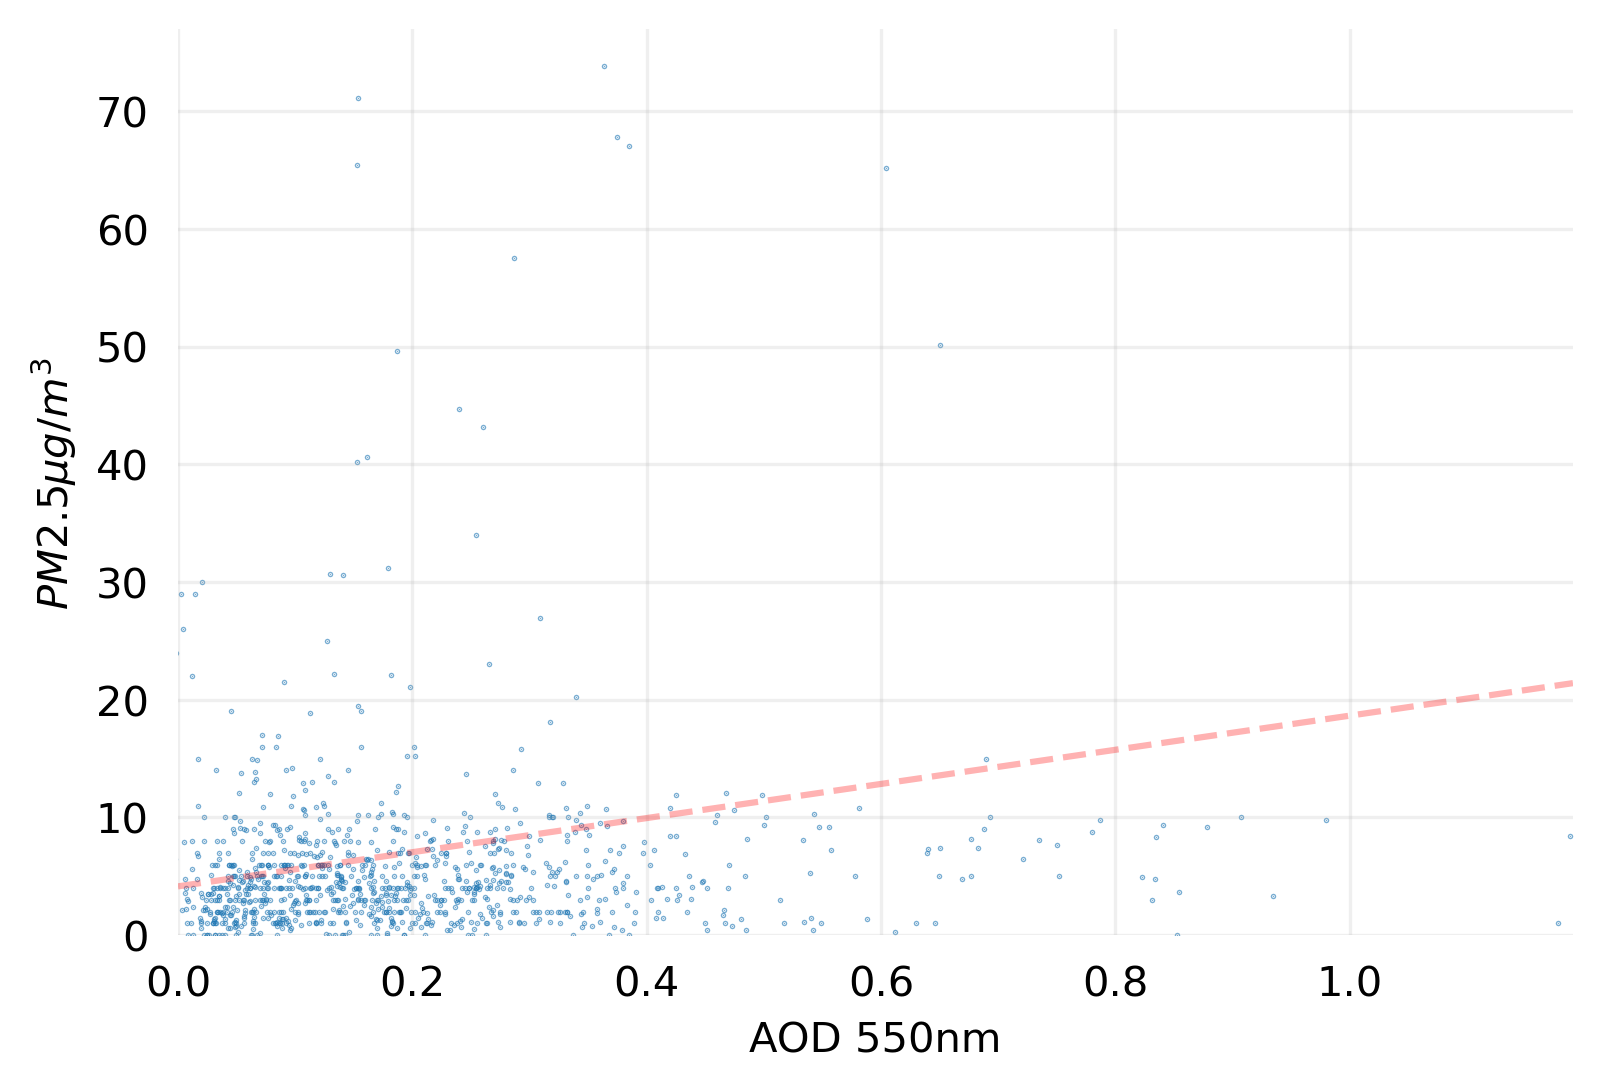

In [39]:
from sklearn.linear_model import LinearRegression
fig, ax = plt.subplots(dpi=300)

x = thing.AOD
y = thing.value

lin = LinearRegression().fit(x.values.reshape(-1, 1), y)

ax.scatter(x, y, s=0.1, alpha=0.6)

ax.axline(xy1=(0, lin.intercept_), slope=lin.coef_.item(), linestyle="--", color="r", alpha=0.3)

ax.set_xlim((0, np.percentile(x, 99)))
ax.set_ylim((0, np.percentile(y, 99)))

ax.set_xlabel('AOD 550nm')
ax.set_ylabel('$PM2.5 µg/m^3$')

ax.tick_params(width=0)
ax.grid(alpha=0.2)
for spine in ['top', 'left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)

In [19]:
df.AOD.describe()

count    37.000000
mean      0.162999
std       0.209976
min       0.006947
25%       0.034843
50%       0.071755
75%       0.146734
max       0.822859
Name: AOD, dtype: float64

In [285]:
df.reset_index().to_csv('data/matched.csv')

In [286]:
df.reset_index().dropna().to_csv('data/matched-no_nan.csv', index=False)

In [45]:
matched = pd.read_csv('data/matched-no_nan.csv', parse_dates=['time'])

In [46]:
matched

time   latitude   longitude  value  proj_longitude  \
0      2021-01-01 13:00:00  25.794222  -80.215556    4.9   -5.114576e+05   
1      2021-01-01 13:00:00  27.290556  -82.507222   10.4   -7.233917e+05   
2      2021-01-01 13:00:00  27.785866  -82.739875   10.8   -7.416869e+05   
3      2021-01-01 13:00:00  27.946688  -82.731767   10.0   -7.396329e+05   
4      2021-01-01 13:00:00  27.955133  -82.469532    9.8   -7.146996e+05   
...                    ...        ...         ...    ...             ...   
643616 2021-12-31 22:00:00  36.270592 -115.238282    2.4   -3.090107e+06   
643617 2021-12-31 23:00:00  32.978330 -115.539170    4.9   -3.247891e+06   
643618 2021-12-31 23:00:00  33.708530 -116.215370    1.7   -3.258185e+06   
643619 2021-12-31 23:00:00  33.719690 -116.189700    4.5   -3.256189e+06   
643620 2021-12-31 23:00:00  33.999580 -117.416010    4.0   -3.316039e+06   

        proj_latitude       AOD  
0        2.703766e+06  0.822859  
1        2.840855e+06  0.343303  
2        2.885996e+06  0.420182  
3        2.900670e+06  0.501750  
4        2.901709e+06  0.786563  
...               ...       ...  
643616   3.500962e+06  0.138026  
643617   3.233972e+06  0.186497  
643618   3.290572e+06  0.084358  
643619   3.291619e+06  0.177905  
643620   3.307956e+06  0.063798  

[643621 rows x 7 columns]

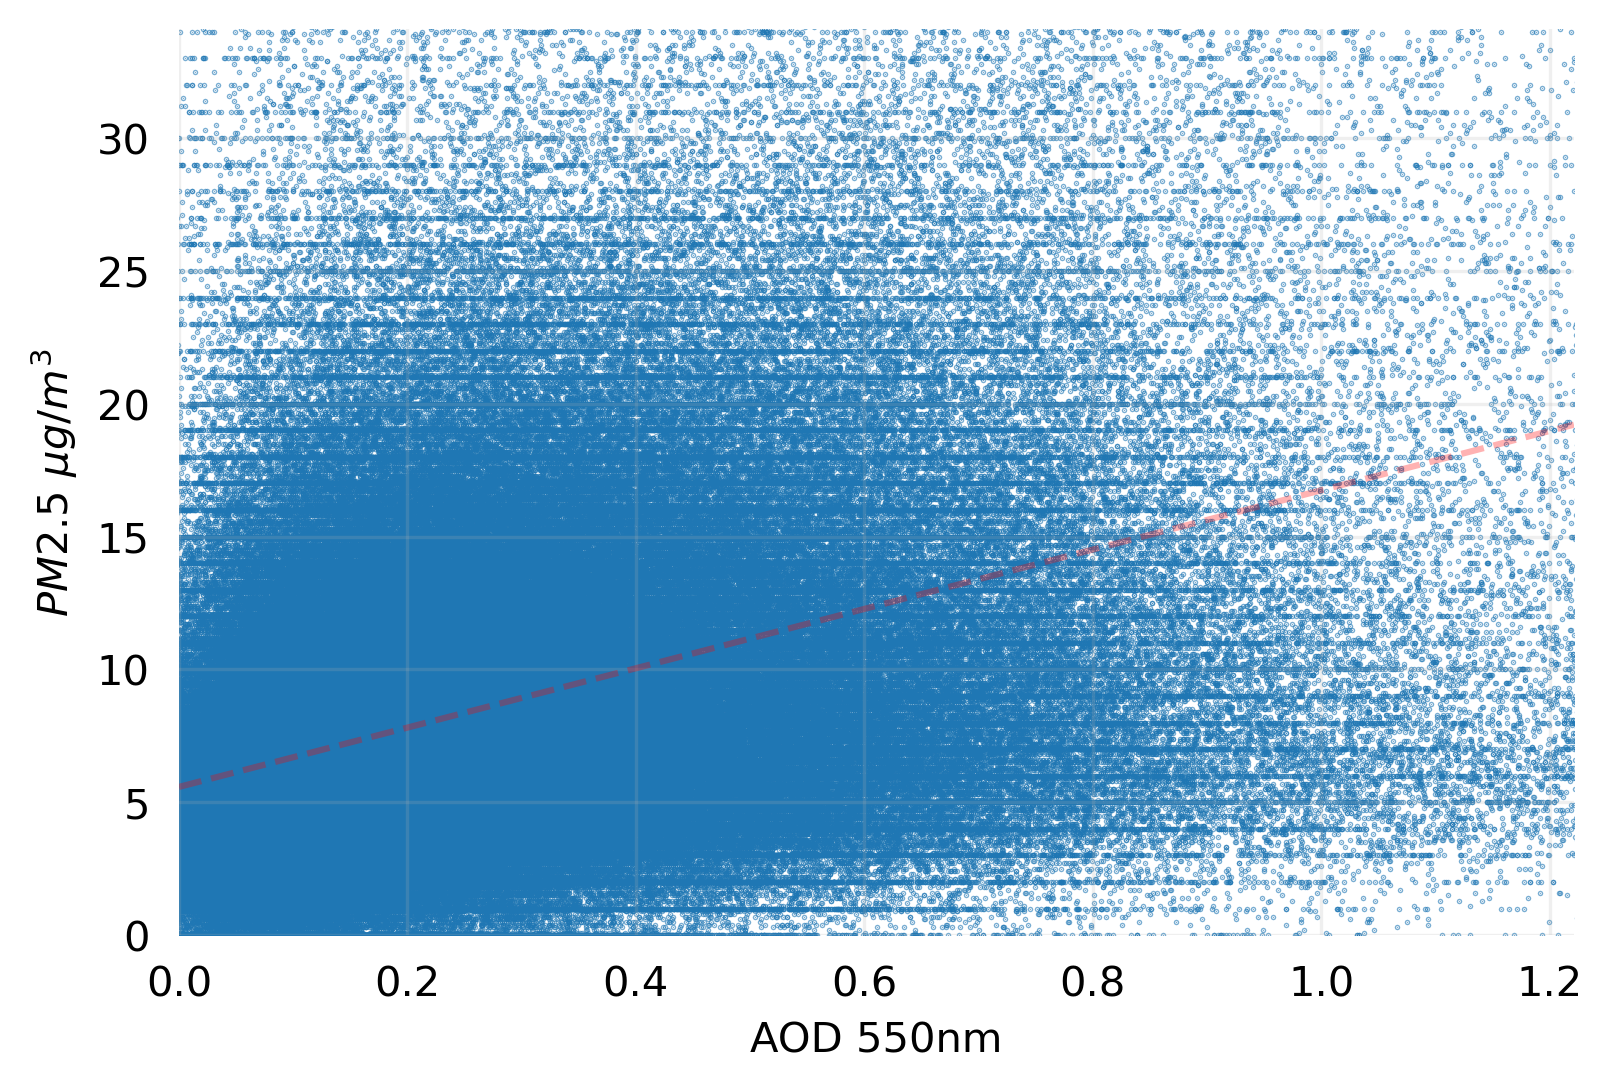

In [47]:
from sklearn.linear_model import LinearRegression
fig, ax = plt.subplots(dpi=300)

x = matched.AOD
y = matched.value

lin = LinearRegression().fit(x.values.reshape(-1, 1), y)

ax.scatter(x, y, s=0.1, alpha=0.6)

ax.axline(xy1=(0, lin.intercept_), slope=lin.coef_.item(), linestyle="--", color="r", alpha=0.3)

ax.set_xlim((0, np.percentile(x, 99)))
ax.set_ylim((0, np.percentile(y, 99)))

ax.set_xlabel('AOD 550nm')
ax.set_ylabel('$PM2.5~ \mu g/m^3$')

ax.tick_params(width=0)
ax.grid(alpha=0.2)
for spine in ['top', 'left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)

# Daily

In [134]:
files = sorted(glob.glob('/Volumes/Shores/GOES/AODC/averages/2021/daily/*.nc'))

In [62]:
pd.read_csv('/Users/kyle/Downloads/daily_88101_2021.csv', parse_dates=['Date Local']).columns.values

array(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name',
       'Sample Duration', 'Pollutant Standard', 'Date Local',
       'Units of Measure', 'Event Type', 'Observation Count',
       'Observation Percent', 'Arithmetic Mean', '1st Max Value',
       '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name',
       'City Name', 'CBSA Name', 'Date of Last Change'], dtype=object)

In [63]:
df = pd.read_csv('/Users/kyle/Downloads/daily_88101_2021.csv', parse_dates=['Date Local'])

df.rename(columns = {
    'Date Local':'time', 
    'Arithmetic Mean': 'value',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace = True)

keep = ['latitude', 'longitude', 'time', 'value','Local Site Name', 'Address', 'State Name', 'County Name','City Name', 'POC']
df.drop(columns=df.columns.difference(keep),inplace=True)

df = df.loc[df.value >= 0]

In [65]:
df

POC   latitude   longitude       time  value  \
0         1  30.497478  -87.880258 2021-01-01    6.4   
1         1  30.497478  -87.880258 2021-01-07    5.7   
2         1  30.497478  -87.880258 2021-01-13   11.0   
3         1  30.497478  -87.880258 2021-01-16    5.1   
4         1  30.497478  -87.880258 2021-01-19   12.7   
...     ...        ...         ...        ...    ...   
588533    3  32.633671 -115.504995 2021-12-27   19.9   
588534    3  32.633671 -115.504995 2021-12-28    6.1   
588535    3  32.633671 -115.504995 2021-12-29   14.6   
588536    3  32.633671 -115.504995 2021-12-30   13.2   
588537    3  32.633671 -115.504995 2021-12-31   11.0   

                                          Local Site Name  \
0                                       FAIRHOPE, Alabama   
1                                       FAIRHOPE, Alabama   
2                                       FAIRHOPE, Alabama   
3                                       FAIRHOPE, Alabama   
4                                       FAIRHOPE, Alabama   
...                                                   ...   
588533  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   
588534  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   
588535  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   
588536  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   
588537  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   

                                                  Address         State Name  \
0       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
1       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
2       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
3       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
4       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
...                                                   ...                ...   
588533           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   
588534           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   
588535           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   
588536           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   
588537           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   

                  County Name City Name  
0                     Baldwin  Fairhope  
1                     Baldwin  Fairhope  
2                     Baldwin  Fairhope  
3                     Baldwin  Fairhope  
4                     Baldwin  Fairhope  
...                       ...       ...  
588533  BAJA CALIFORNIA NORTE  Mexicali  
588534  BAJA CALIFORNIA NORTE  Mexicali  
588535  BAJA CALIFORNIA NORTE  Mexicali  
588536  BAJA CALIFORNIA NORTE  Mexicali  
588537  BAJA CALIFORNIA NORTE  Mexicali  

[586357 rows x 10 columns]

In [66]:
transformed = geo.transform_points(src_crs=plate, x=df['longitude'], y=df['latitude'])
df['proj_longitude'] = transformed[:,0]
df['proj_latitude'] = transformed[:,1]

In [67]:
sat_h = aod.goes_imager_projection.perspective_point_height
minx, maxx = aod.x.min().item() * sat_h, aod.x.max().item() * sat_h
miny, maxy = aod.y.min().item() * sat_h, aod.y.max().item() * sat_h

In [68]:
# drop locations that are not observable by GOES-16
df = df[
    (df.proj_longitude >= minx) & 
    (df.proj_longitude <= maxx) & 
    (df.proj_latitude >= miny) & 
    (df.proj_latitude <= maxy)
]

In [69]:
df

POC   latitude   longitude       time  value  \
0         1  30.497478  -87.880258 2021-01-01    6.4   
1         1  30.497478  -87.880258 2021-01-07    5.7   
2         1  30.497478  -87.880258 2021-01-13   11.0   
3         1  30.497478  -87.880258 2021-01-16    5.1   
4         1  30.497478  -87.880258 2021-01-19   12.7   
...     ...        ...         ...        ...    ...   
588533    3  32.633671 -115.504995 2021-12-27   19.9   
588534    3  32.633671 -115.504995 2021-12-28    6.1   
588535    3  32.633671 -115.504995 2021-12-29   14.6   
588536    3  32.633671 -115.504995 2021-12-30   13.2   
588537    3  32.633671 -115.504995 2021-12-31   11.0   

                                          Local Site Name  \
0                                       FAIRHOPE, Alabama   
1                                       FAIRHOPE, Alabama   
2                                       FAIRHOPE, Alabama   
3                                       FAIRHOPE, Alabama   
4                                       FAIRHOPE, Alabama   
...                                                   ...   
588533  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   
588534  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   
588535  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   
588536  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   
588537  COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...   

                                                  Address         State Name  \
0       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
1       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
2       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
3       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
4       FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...            Alabama   
...                                                   ...                ...   
588533           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   
588534           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   
588535           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   
588536           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   
588537           COBACH, COLEGIO DE BACHILLERES, MEXICALI  Country Of Mexico   

                  County Name City Name  proj_longitude  proj_latitude  
0                     Baldwin  Fairhope   -1.187314e+06   3.121229e+06  
1                     Baldwin  Fairhope   -1.187314e+06   3.121229e+06  
2                     Baldwin  Fairhope   -1.187314e+06   3.121229e+06  
3                     Baldwin  Fairhope   -1.187314e+06   3.121229e+06  
4                     Baldwin  Fairhope   -1.187314e+06   3.121229e+06  
...                       ...       ...             ...            ...  
588533  BAJA CALIFORNIA NORTE  Mexicali   -3.259868e+06   3.205527e+06  
588534  BAJA CALIFORNIA NORTE  Mexicali   -3.259868e+06   3.205527e+06  
588535  BAJA CALIFORNIA NORTE  Mexicali   -3.259868e+06   3.205527e+06  
588536  BAJA CALIFORNIA NORTE  Mexicali   -3.259868e+06   3.205527e+06  
588537  BAJA CALIFORNIA NORTE  Mexicali   -3.259868e+06   3.205527e+06  

[573552 rows x 12 columns]

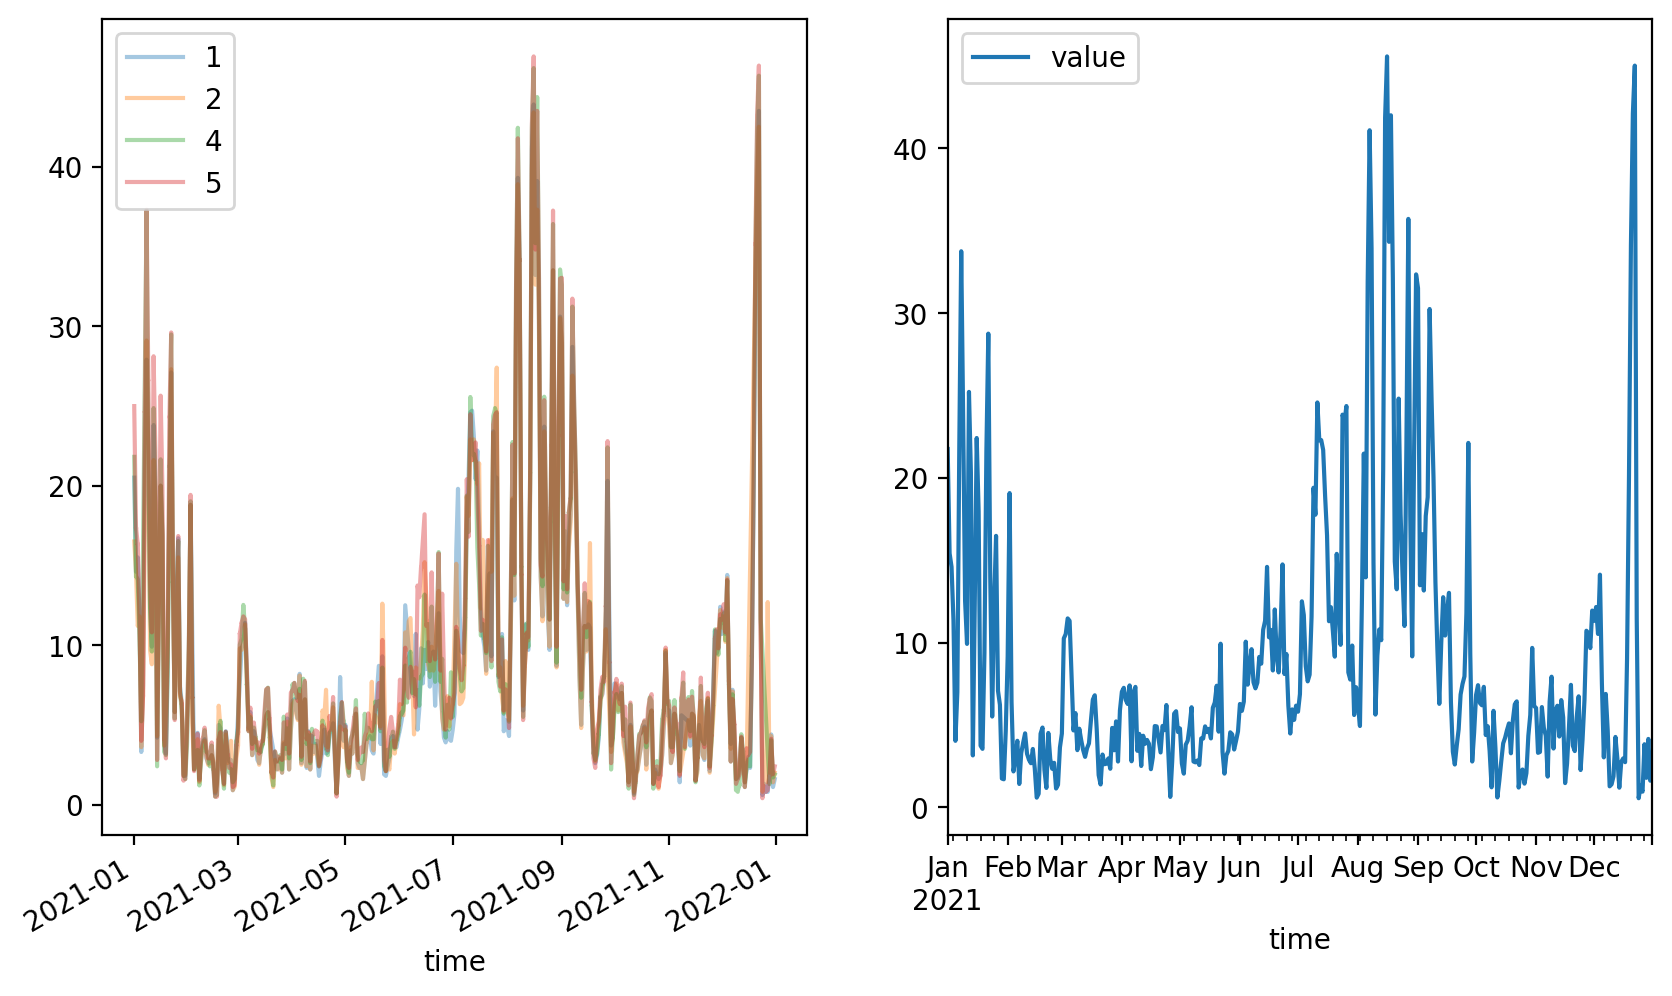

In [118]:
x = 0
for g, adf in df.groupby(['longitude', 'latitude']):
#     print(adf.POC.unique(), adf.POC.unique().shape)
    try:
        if adf.POC.unique().shape[0] > 3:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6), dpi=200)
            adf.set_index('time').sort_index().groupby('POC').value.plot(legend=True, ax=ax1, alpha=0.4)
            adf.groupby('time').mean().sort_index().value.plot(legend=True, ax=ax2)
#             x += 1
#             if x > 10:
            raise StopIteration
    except:
        break

In [126]:
# for locations that have more than one observation at the same time, average them
df = df.groupby(['longitude', 'latitude', 'time']).mean()
df.reset_index(inplace=True)

In [127]:
df

longitude   latitude       time  POC  value  proj_longitude  \
0      -124.179490  40.776780 2021-01-01  1.0    6.8   -3.330026e+06   
1      -124.179490  40.776780 2021-01-04  1.0    6.4   -3.330026e+06   
2      -124.179490  40.776780 2021-01-07  1.0    4.7   -3.330026e+06   
3      -124.179490  40.776780 2021-01-10  1.0   15.2   -3.330026e+06   
4      -124.179490  40.776780 2021-01-13  1.0   12.6   -3.330026e+06   
...            ...        ...        ...  ...    ...             ...   
274987  -64.784868  17.712474 2021-11-30  3.0    2.8    1.064197e+06   
274988  -64.784868  17.712474 2021-12-06  3.0    3.8    1.064197e+06   
274989  -64.784868  17.712474 2021-12-18  3.0    3.9    1.064197e+06   
274990  -64.784868  17.712474 2021-12-24  3.0    3.5    1.064197e+06   
274991  -64.784868  17.712474 2021-12-30  3.0    4.2    1.064197e+06   

        proj_latitude  
0        3.787764e+06  
1        3.787764e+06  
2        3.787764e+06  
3        3.787764e+06  
4        3.787764e+06  
...               ...  
274987   1.905148e+06  
274988   1.905148e+06  
274989   1.905148e+06  
274990   1.905148e+06  
274991   1.905148e+06  

[274992 rows x 7 columns]

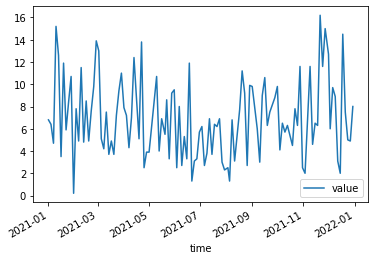

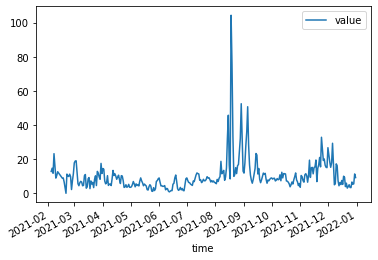

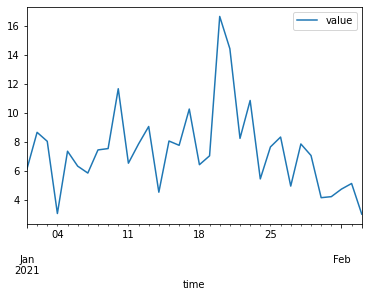

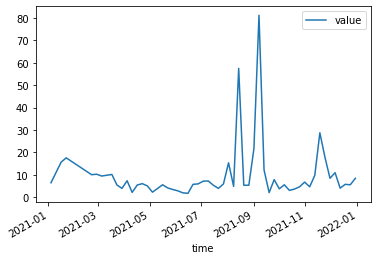

In [130]:
x = 0
for g, adf in df.groupby(['longitude', 'latitude']):
    try:
        fig, ax = plt.subplots()
        adf.set_index('time').sort_index().value.plot(legend=True, ax=ax)
        x += 1
        if x > 3:
            raise StopIteration
    except:
        break

In [131]:
empty = np.empty(df.shape[0])
empty[:] = np.nan
df['AOD'] = empty

In [132]:
df.set_index(['time', 'longitude', 'latitude'], inplace=True)
df.sort_index(inplace=True)

In [133]:
df

POC      value  proj_longitude  \
time       longitude   latitude                                    
2021-01-01 -124.179490 40.776780  1.0   6.800000   -3.330026e+06   
           -123.352640 39.411740  3.0   6.115217   -3.365376e+06   
           -123.206550 39.150470  3.0  14.612500   -3.372244e+06   
           -123.141352 44.067224  1.0   1.916666   -3.101428e+06   
           -123.083737 44.026312  1.0   2.000000   -3.101230e+06   
...                               ...        ...             ...   
2021-12-31 -70.268965  43.660246  3.0  10.837500    3.607385e+05   
           -68.772762  44.817398  2.0   7.133333    4.638504e+05   
           -68.321106  47.355332  2.0   9.204166    4.722074e+05   
           -68.260900  44.377050  3.0   0.300000    5.060534e+05   
           -68.016195  46.682299  2.0   7.725000    5.006529e+05   

                                  proj_latitude  AOD  
time       longitude   latitude                       
2021-01-01 -124.179490 40.776780   3.787764e+06  NaN  
           -123.352640 39.411740   3.693570e+06  NaN  
           -123.206550 39.150470   3.675155e+06  NaN  
           -123.141352 44.067224   4.022256e+06  NaN  
           -123.083737 44.026312   4.019869e+06  NaN  
...                                         ...  ...  
2021-12-31 -70.268965  43.660246   4.155362e+06  NaN  
           -68.772762  44.817398   4.230693e+06  NaN  
           -68.321106  47.355332   4.390150e+06  NaN  
           -68.260900  44.377050   4.201306e+06  NaN  
           -68.016195  46.682299   4.348521e+06  NaN  

[274992 rows x 5 columns]

In [143]:
matched_pm = 0
not_matched_pm = 0

pbar = tqdm(files)
for day_file in pbar:
    with xr.open_dataset(day_file) as ds:
        ds.load()
    sat_h = ds.goes_imager_projection.perspective_point_height
    ds = ds.assign_coords(x=ds.x*sat_h, y = ds.y*sat_h)

    tm = pd.to_datetime(ds.t.item()).strftime('%Y-%m-%d')
    if np.isfinite(ds.AOD).any():
        sub = df.loc[tm]
        for (lon, lat), row in sub.iterrows():
            try:
                data = ds.sel(
                    x=row.proj_longitude, 
                    y=row.proj_latitude, 
                    method='nearest', 
                    tolerance=2000
                )
                if np.isfinite(data.AOD):
                    df.loc[(tm, lon, lat), 'AOD'] = data.AOD.item()
                    matched_pm += 1
            except Exception as e:
                not_matched_pm += 1

  0%|          | 0/365 [00:00<?, ?it/s]

In [146]:
df.reset_index().to_csv('data/matched.csv', index=False)

In [145]:
df.reset_index().dropna().to_csv('data/matched-no_nan.csv', index=False)

In [272]:
matched = pd.read_csv('data/matched-no_nan.csv', parse_dates=['time'])

In [273]:
matched

time   longitude   latitude       POC      value  proj_longitude  \
0      2021-01-01 -117.675930  33.630030  1.000000   3.700000   -3.346970e+06   
1      2021-01-01 -117.617220  34.030833  2.333333   8.758333   -3.326257e+06   
2      2021-01-01 -117.492010  34.100020  1.000000   3.800000   -3.316060e+06   
3      2021-01-01 -117.416010  33.999580  6.333333   1.422222   -3.316039e+06   
4      2021-01-01 -117.325540  34.510961  1.500000  10.158333   -3.288587e+06   
...           ...         ...        ...       ...        ...             ...   
132277 2021-12-31  -77.012816  38.875161  1.000000   5.745833   -1.670613e+05   
132278 2021-12-31  -76.958072  38.895572  1.000000   5.612500   -1.624668e+05   
132279 2021-12-31  -76.953426  38.894770  1.000000   7.837500   -1.620836e+05   
132280 2021-12-31  -76.059210  43.052350  4.000000  12.216667   -8.180915e+04   
132281 2021-12-31  -73.821530  40.736140  4.000000  18.339583    9.485095e+04   

        proj_latitude       AOD  
0        3.276413e+06  0.026075  
1        3.309417e+06  0.046046  
2        3.315712e+06  0.074804  
3        3.307956e+06  0.052775  
4        3.349871e+06  0.073041  
...               ...       ...  
132277   3.816162e+06  0.240285  
132278   3.817712e+06  0.294921  
132279   3.817653e+06  0.418024  
132280   4.115855e+06  0.211089  
132281   3.953348e+06  0.462988  

[132282 rows x 8 columns]

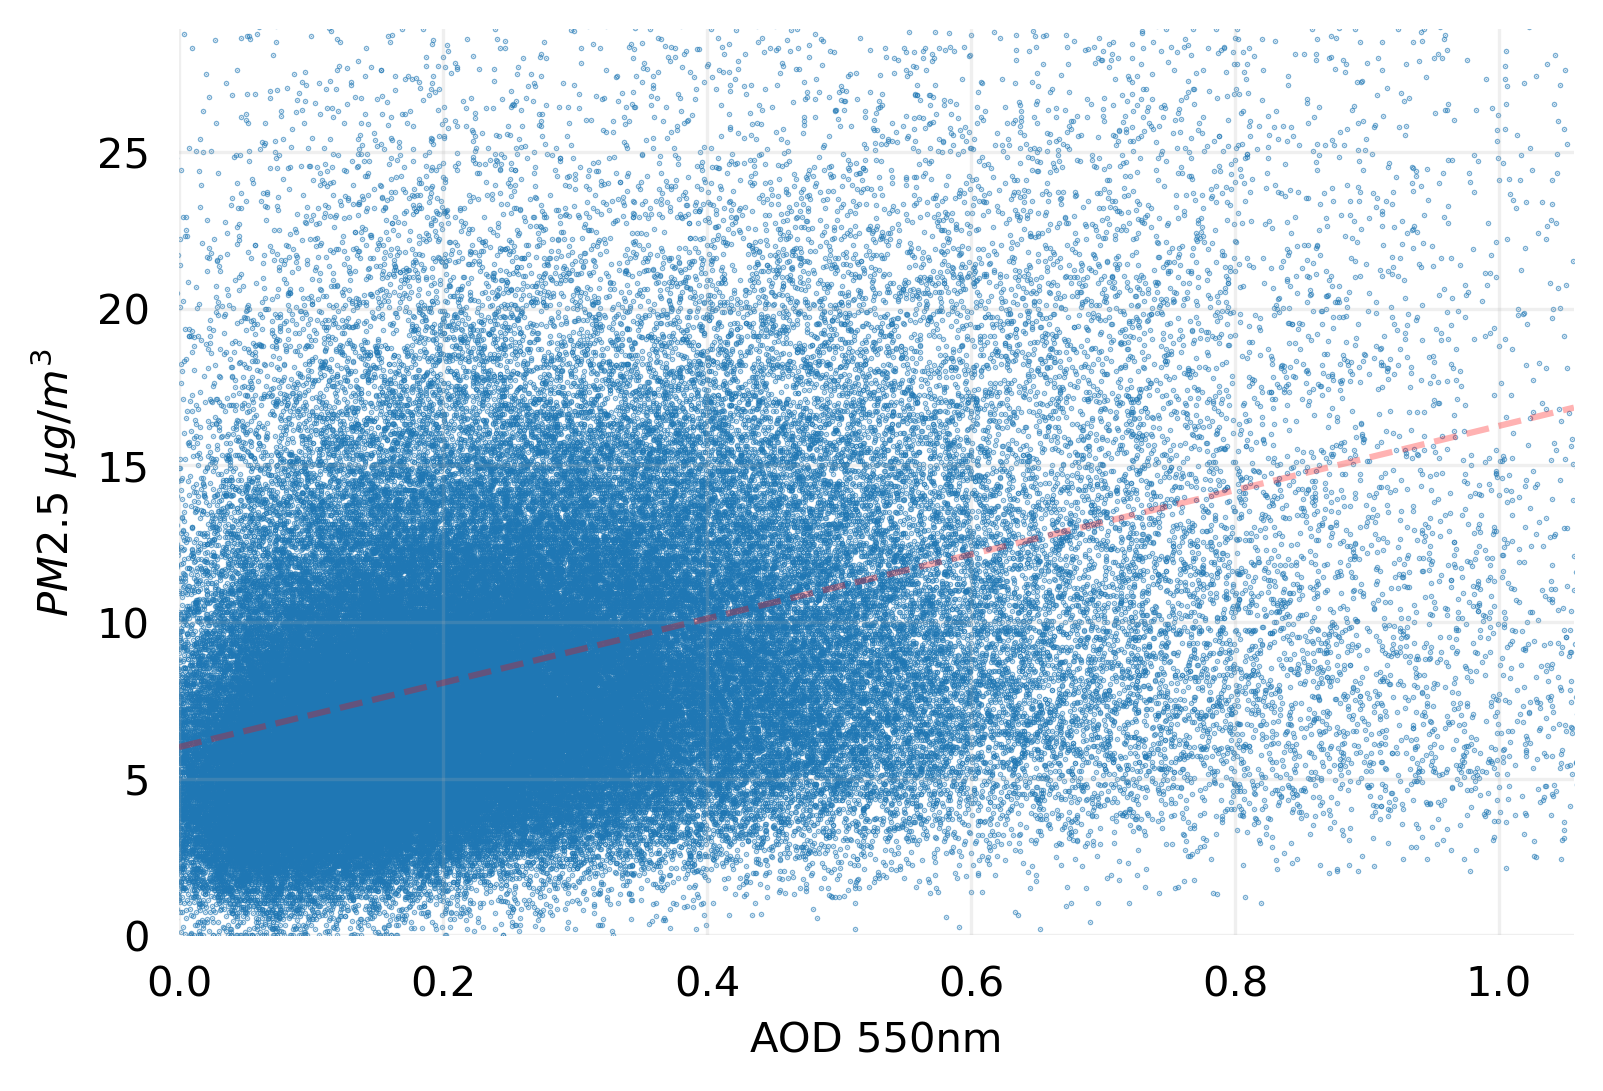

In [149]:
from sklearn.linear_model import LinearRegression
fig, ax = plt.subplots(dpi=300)

x = matched.AOD
y = matched.value

lin = LinearRegression().fit(x.values.reshape(-1, 1), y)

ax.scatter(x, y, s=0.1, alpha=0.6)

ax.axline(xy1=(0, lin.intercept_), slope=lin.coef_.item(), linestyle="--", color="r", alpha=0.3)

ax.set_xlim((0, np.percentile(x, 99)))
ax.set_ylim((0, np.percentile(y, 99)))

ax.set_xlabel('AOD 550nm')
ax.set_ylabel('$PM2.5~ \mu g/m^3$')

ax.tick_params(width=0)
ax.grid(alpha=0.2)
for spine in ['top', 'left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)

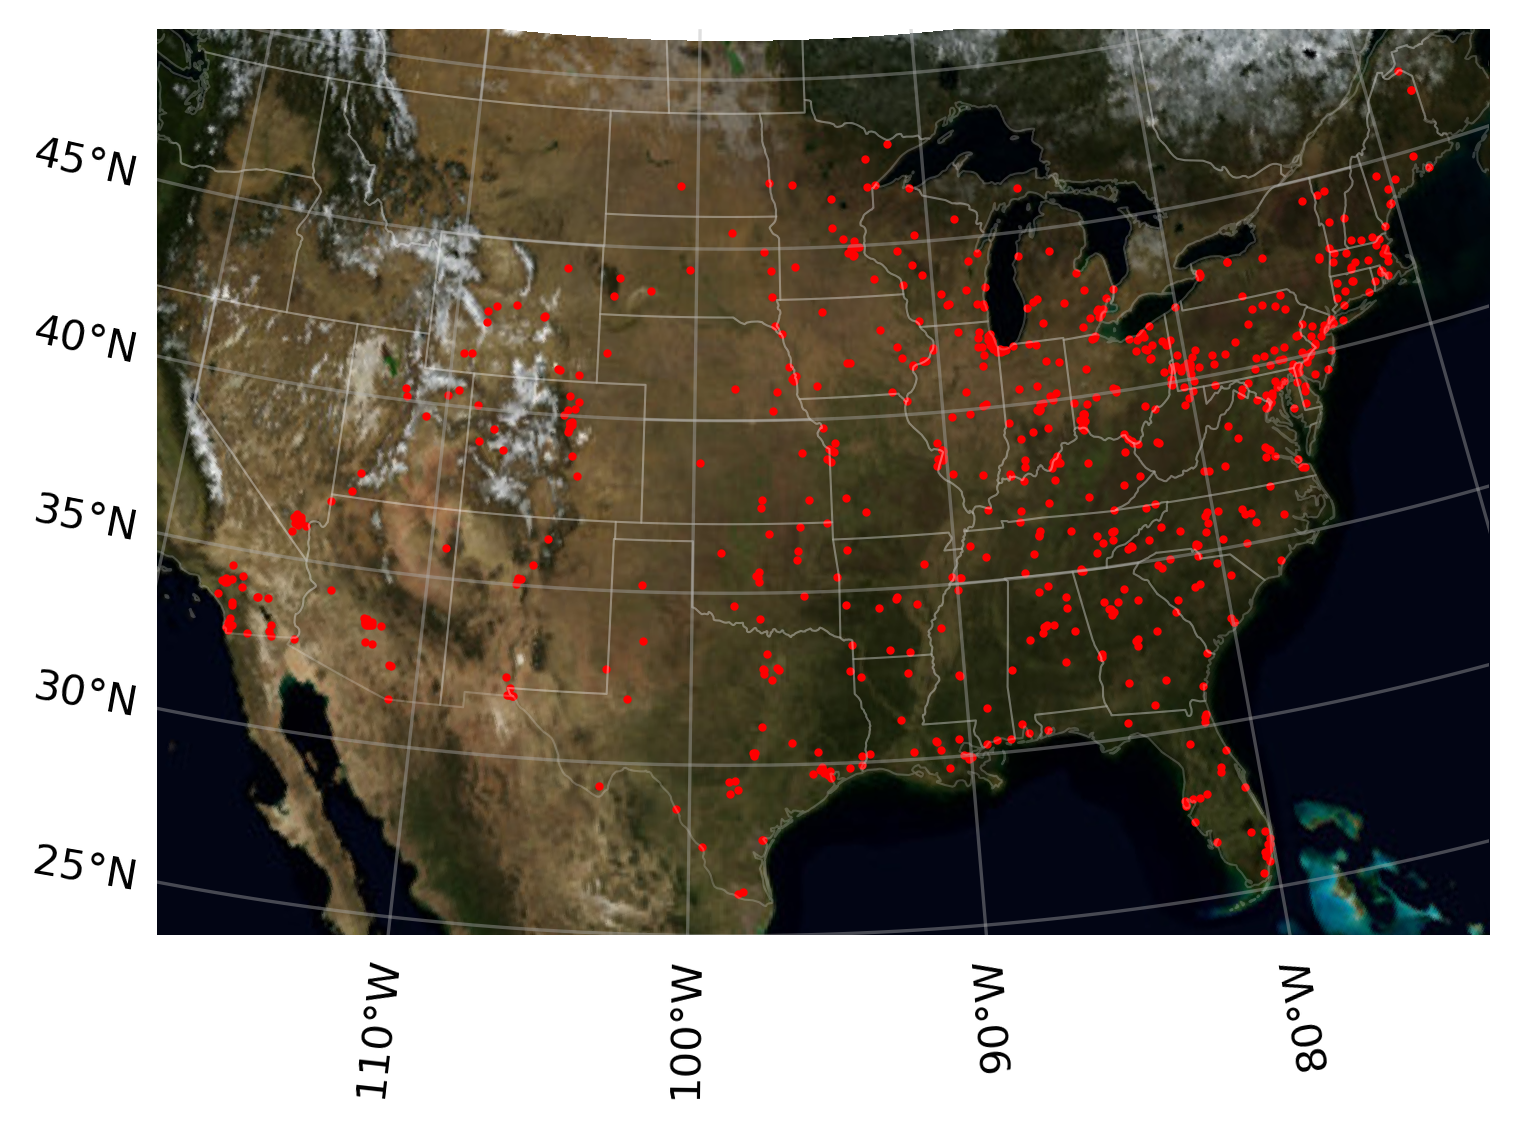

In [161]:
locations = matched[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': equal_area})

ax.scatter(locations.longitude, locations.latitude, 
           s=1, 
#            alpha=0.3, 
           color='red', 
           transform=plate)

# https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS&request=GetCapabilities
ax.add_wms(wms='https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS',
               layers=['BlueMarbleNG'])

ax.add_feature(cfeature.STATES, edgecolor='white', alpha=0.2, lw=0.5)

gl = ax.gridlines(draw_labels=True, alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax.spines['geo'].set_visible(False)

In [173]:
met = ['data/daily_TEMP_2021.csv',
 'data/daily_PRESS_2021.csv',
 'data/daily_WIND_2021.csv',
 'data/daily_RH_DP_2021.csv',]
dfs = [
    pd.read_csv(f, 
        parse_dates=['Date Local'], 
        usecols=[
       'Latitude', 'Longitude', 'Parameter Name', 'Date Local',
       'Units of Measure', 'Arithmetic Mean'
        ]
) for f in met]

In [184]:
meteo = pd.concat(dfs, axis=0)

In [275]:
empty = np.empty(matched.shape[0])
empty[:] = np.nan
for c in meteo['Parameter Name'].unique():
    matched[c] = empty

In [274]:
meteo.reset_index(inplace=True)

In [276]:
meteo.set_index([ 'Parameter Name', 'Longitude', 'Latitude', 'Date Local'], inplace=True)
meteo

Units of Measure  \
Parameter Name      Longitude  Latitude Date Local                              
Outdoor Temperature -87.54350  31.09210 2021-01-01         Degrees Fahrenheit   
                                        2021-01-02         Degrees Fahrenheit   
                                        2021-01-03         Degrees Fahrenheit   
                                        2021-01-04         Degrees Fahrenheit   
                                        2021-01-05         Degrees Fahrenheit   
...                                                                       ...   
Relative Humidity   -104.20512 43.84539 2021-12-27  Percent relative humidity   
                                        2021-12-28  Percent relative humidity   
                                        2021-12-29  Percent relative humidity   
                                        2021-12-30  Percent relative humidity   
                                        2021-12-31  Percent relative humidity   

                                                    Arithmetic Mean  
Parameter Name      Longitude  Latitude Date Local                   
Outdoor Temperature -87.54350  31.09210 2021-01-01        63.875000  
                                        2021-01-02        51.141667  
                                        2021-01-03        44.666667  
                                        2021-01-04        48.120833  
                                        2021-01-05        50.079167  
...                                                             ...  
Relative Humidity   -104.20512 43.84539 2021-12-27        63.375000  
                                        2021-12-28        72.541667  
                                        2021-12-29        71.208333  
                                        2021-12-30        60.833333  
                                        2021-12-31        82.625000  

[1011396 rows x 2 columns]

In [277]:
matched.set_index(['longitude', 'latitude', 'time'], inplace=True)
matched

POC      value  proj_longitude  \
longitude   latitude  time                                              
-117.675930 33.630030 2021-01-01  1.000000   3.700000   -3.346970e+06   
-117.617220 34.030833 2021-01-01  2.333333   8.758333   -3.326257e+06   
-117.492010 34.100020 2021-01-01  1.000000   3.800000   -3.316060e+06   
-117.416010 33.999580 2021-01-01  6.333333   1.422222   -3.316039e+06   
-117.325540 34.510961 2021-01-01  1.500000  10.158333   -3.288587e+06   
...                                    ...        ...             ...   
-77.012816  38.875161 2021-12-31  1.000000   5.745833   -1.670613e+05   
-76.958072  38.895572 2021-12-31  1.000000   5.612500   -1.624668e+05   
-76.953426  38.894770 2021-12-31  1.000000   7.837500   -1.620836e+05   
-76.059210  43.052350 2021-12-31  4.000000  12.216667   -8.180915e+04   
-73.821530  40.736140 2021-12-31  4.000000  18.339583    9.485095e+04   

                                  proj_latitude       AOD  \
longitude   latitude  time                                  
-117.675930 33.630030 2021-01-01   3.276413e+06  0.026075   
-117.617220 34.030833 2021-01-01   3.309417e+06  0.046046   
-117.492010 34.100020 2021-01-01   3.315712e+06  0.074804   
-117.416010 33.999580 2021-01-01   3.307956e+06  0.052775   
-117.325540 34.510961 2021-01-01   3.349871e+06  0.073041   
...                                         ...       ...   
-77.012816  38.875161 2021-12-31   3.816162e+06  0.240285   
-76.958072  38.895572 2021-12-31   3.817712e+06  0.294921   
-76.953426  38.894770 2021-12-31   3.817653e+06  0.418024   
-76.059210  43.052350 2021-12-31   4.115855e+06  0.211089   
-73.821530  40.736140 2021-12-31   3.953348e+06  0.462988   

                                  Outdoor Temperature  Barometric pressure  \
longitude   latitude  time                                                   
-117.675930 33.630030 2021-01-01                  NaN                  NaN   
-117.617220 34.030833 2021-01-01                  NaN                  NaN   
-117.492010 34.100020 2021-01-01                  NaN                  NaN   
-117.416010 33.999580 2021-01-01                  NaN                  NaN   
-117.325540 34.510961 2021-01-01                  NaN                  NaN   
...                                               ...                  ...   
-77.012816  38.875161 2021-12-31                  NaN                  NaN   
-76.958072  38.895572 2021-12-31                  NaN                  NaN   
-76.953426  38.894770 2021-12-31                  NaN                  NaN   
-76.059210  43.052350 2021-12-31                  NaN                  NaN   
-73.821530  40.736140 2021-12-31                  NaN                  NaN   

                                  Wind Speed - Resultant  \
longitude   latitude  time                                 
-117.675930 33.630030 2021-01-01                     NaN   
-117.617220 34.030833 2021-01-01                     NaN   
-117.492010 34.100020 2021-01-01                     NaN   
-117.416010 33.999580 2021-01-01                     NaN   
-117.325540 34.510961 2021-01-01                     NaN   
...                                                  ...   
-77.012816  38.875161 2021-12-31                     NaN   
-76.958072  38.895572 2021-12-31                     NaN   
-76.953426  38.894770 2021-12-31                     NaN   
-76.059210  43.052350 2021-12-31                     NaN   
-73.821530  40.736140 2021-12-31                     NaN   

                                  Wind Direction - Resultant  \
longitude   latitude  time                                     
-117.675930 33.630030 2021-01-01                         NaN   
-117.617220 34.030833 2021-01-01                         NaN   
-117.492010 34.100020 2021-01-01                         NaN   
-117.416010 33.999580 2021-01-01                         NaN   
-117.325540 34.510961 2021-01-01                         NaN   
...                                                

In [283]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for col in meteo.index.levels[0]:
    sub = meteo.loc[col]
    for (lon, lat, time), adf in matched.groupby(['longitude', 'latitude', 'time']):
        try:
            matched.loc[(lon, lat, time), col] = sub.loc[(lon, lat, '2021-01-01'), 'Arithmetic Mean'].mean()
        except KeyError:
            continue

In [288]:
matched.reset_index().to_csv('data/matched-with-met.csv', index=False)

In [289]:
matched.describe()

POC          value  proj_longitude  proj_latitude  \
count  132282.000000  132282.000000    1.322820e+05   1.322820e+05   
mean        2.716325       8.802210   -1.189576e+06   3.667907e+06   
std         1.305879       5.746745    9.936727e+05   3.746341e+05   
min         1.000000       0.000000   -3.354953e+06   2.673276e+06   
25%         2.000000       5.261218   -1.849956e+06   3.392689e+06   
50%         3.000000       7.533333   -9.699685e+05   3.766235e+06   
75%         3.000000      10.804166   -4.623692e+05   3.957464e+06   
max        11.000000     222.410416    5.060534e+05   4.408975e+06   

                 AOD  Outdoor Temperature  Barometric pressure  \
count  132282.000000         46801.000000         22844.000000   
mean        0.272992            37.837671           985.377553   
std         0.223329            11.820817            47.555525   
min        -0.049923             7.833333           747.141667   
25%         0.125381            29.666667           981.979167   
50%         0.217631            35.108333           993.837500   
75%         0.358187            45.558333          1014.911111   
max         3.582377            76.583333          1084.387500   

       Wind Speed - Resultant  Wind Direction - Resultant  Relative Humidity   \
count            43304.000000                43853.000000        30438.000000   
mean                 4.044254                  179.913621           74.979610   
std                  2.286895                   72.311485           20.271128   
min                  0.000000                    0.000000           21.916667   
25%                  2.262500                  125.500000           66.625000   
50%                  3.812500                  175.166667           80.958333   
75%                  5.566667                  234.666667           89.958333   
max                 12.283333                  333.320833          100.000000   

         Dew Point  
count  3356.000000  
mean     28.877657  
std       6.980519  
min      10.791667  
25%      25.708333  
50%      32.666667  
75%      33.333333  
max      38.500000

In [293]:
with xr.open_dataset('/Volumes/Shores/ERA5/adaptor.mars.internal-1657556096.126938-20233-10-8071570c-1974-4ff0-9783-fda8b3809de2.nc') as ds:
    ds.load()

In [294]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 361, latitude: 201, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -135.0 -134.8 -134.5 ... -45.5 -45.25 -45.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 -4.06 -5.895 ... -5.596 -5.64
    v100       (time, latitude, longitude) float32 16.77 16.88 ... -6.442 -6.439
    u10        (time, latitude, longitude) float32 -3.32 -4.593 ... -4.991
    v10        (time, latitude, longitude) float32 12.32 12.35 ... -5.758 -5.741
    d2m        (time, latitude, longitude) float32 281.3 281.0 ... 297.2 297.1
    t2m        (time, latitude, longitude) float32 282.4 282.4 ... 298.9 299.0
    blh        (time, latitude, longitude) float32 726.8 743.8 ... 697.3 742.5
    lai_hv     (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lai_lv     (time, latitude, longitude) float32 2.384e-07 ... 2.384e-07
    slt        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sp         (time, latitude, longitude) float32 9.969e+04 ... 1.011e+05
    tp         (time, latitude, longitude) float32 0.002876 ... 0.001508
Attributes:
    Conventions:  CF-1.6
    history:      2022-07-11 17:51:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [295]:
with xr.open_dataset('/Volumes/Shores/ERA5/download-era5_land.nc') as ds2:
    ds2.load()

In [296]:
ds2

<xarray.Dataset>
Dimensions:    (longitude: 901, latitude: 501, time: 365)
Coordinates:
  * longitude  (longitude) float32 -135.0 -134.9 -134.8 ... -45.2 -45.1 -45.0
  * latitude   (latitude) float32 50.0 49.9 49.8 49.7 ... 0.3 0.2 0.1 -4.416e-13
  * time       (time) datetime64[ns] 2021-01-01T12:00:00 ... 2021-12-31T12:00:00
Data variables:
    u10        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    v10        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    d2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    lai_hv     (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    lai_lv     (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    sp         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    tp         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-07-06 14:55:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

# Some Graphs

In [56]:
df.reset_index(inplace=True)

In [94]:
march = [j for n in range(31 + 28,31 + 28 + 31 + 1) for j in files[f'{n:03}']]

In [95]:
ds = xr.open_mfdataset(
    march,
    concat_dim="t", 
    parallel=True, 
    combine='nested',
    data_vars='different',
).compute()

In [108]:
sat_h = ds.goes_imager_projection.perspective_point_height
ds = ds.assign_coords(x=ds.x*sat_h, y = ds.y*sat_h)

In [ ]:
fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': equal_area})

ds.isel(t=16).AOD.plot(ax=ax, vmin=0, vmax=1, transform=geo, cmap='Reds')

# https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS&request=GetCapabilities
ax.add_wms(wms='https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS',
               layers=['BlueMarbleNG'])

ax.add_feature(cfeature.STATES, edgecolor='white', alpha=0.2, linewidth=0.5)

gl = ax.gridlines(draw_labels=True, alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax.spines['geo'].set_visible(False);

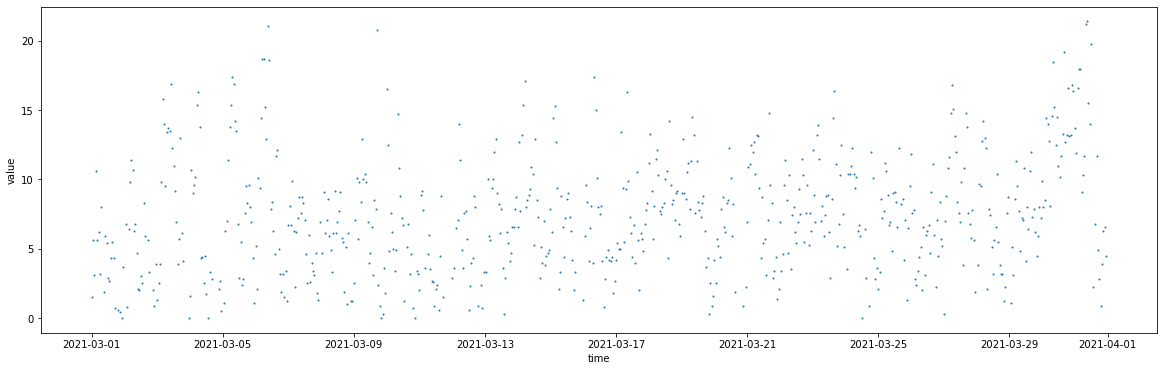

In [117]:
for g, adf in df.groupby(['longitude', 'latitude']):
    a = geo.transform_points(src_crs=plate, x=g[0], y=g[1])
    x, y = a[:, 0][0], a[:, 1][0]
    if np.isfinite(ds.sel(x=x, y=y, method='nearest').AOD).any():
        fig, ax = plt.subplots(figsize=(20,6))
        adf.set_index('time').loc['2021-03-01':'2021-03-31'].reset_index().plot.scatter(x='time', y='value', ax=ax, s=1)
        break

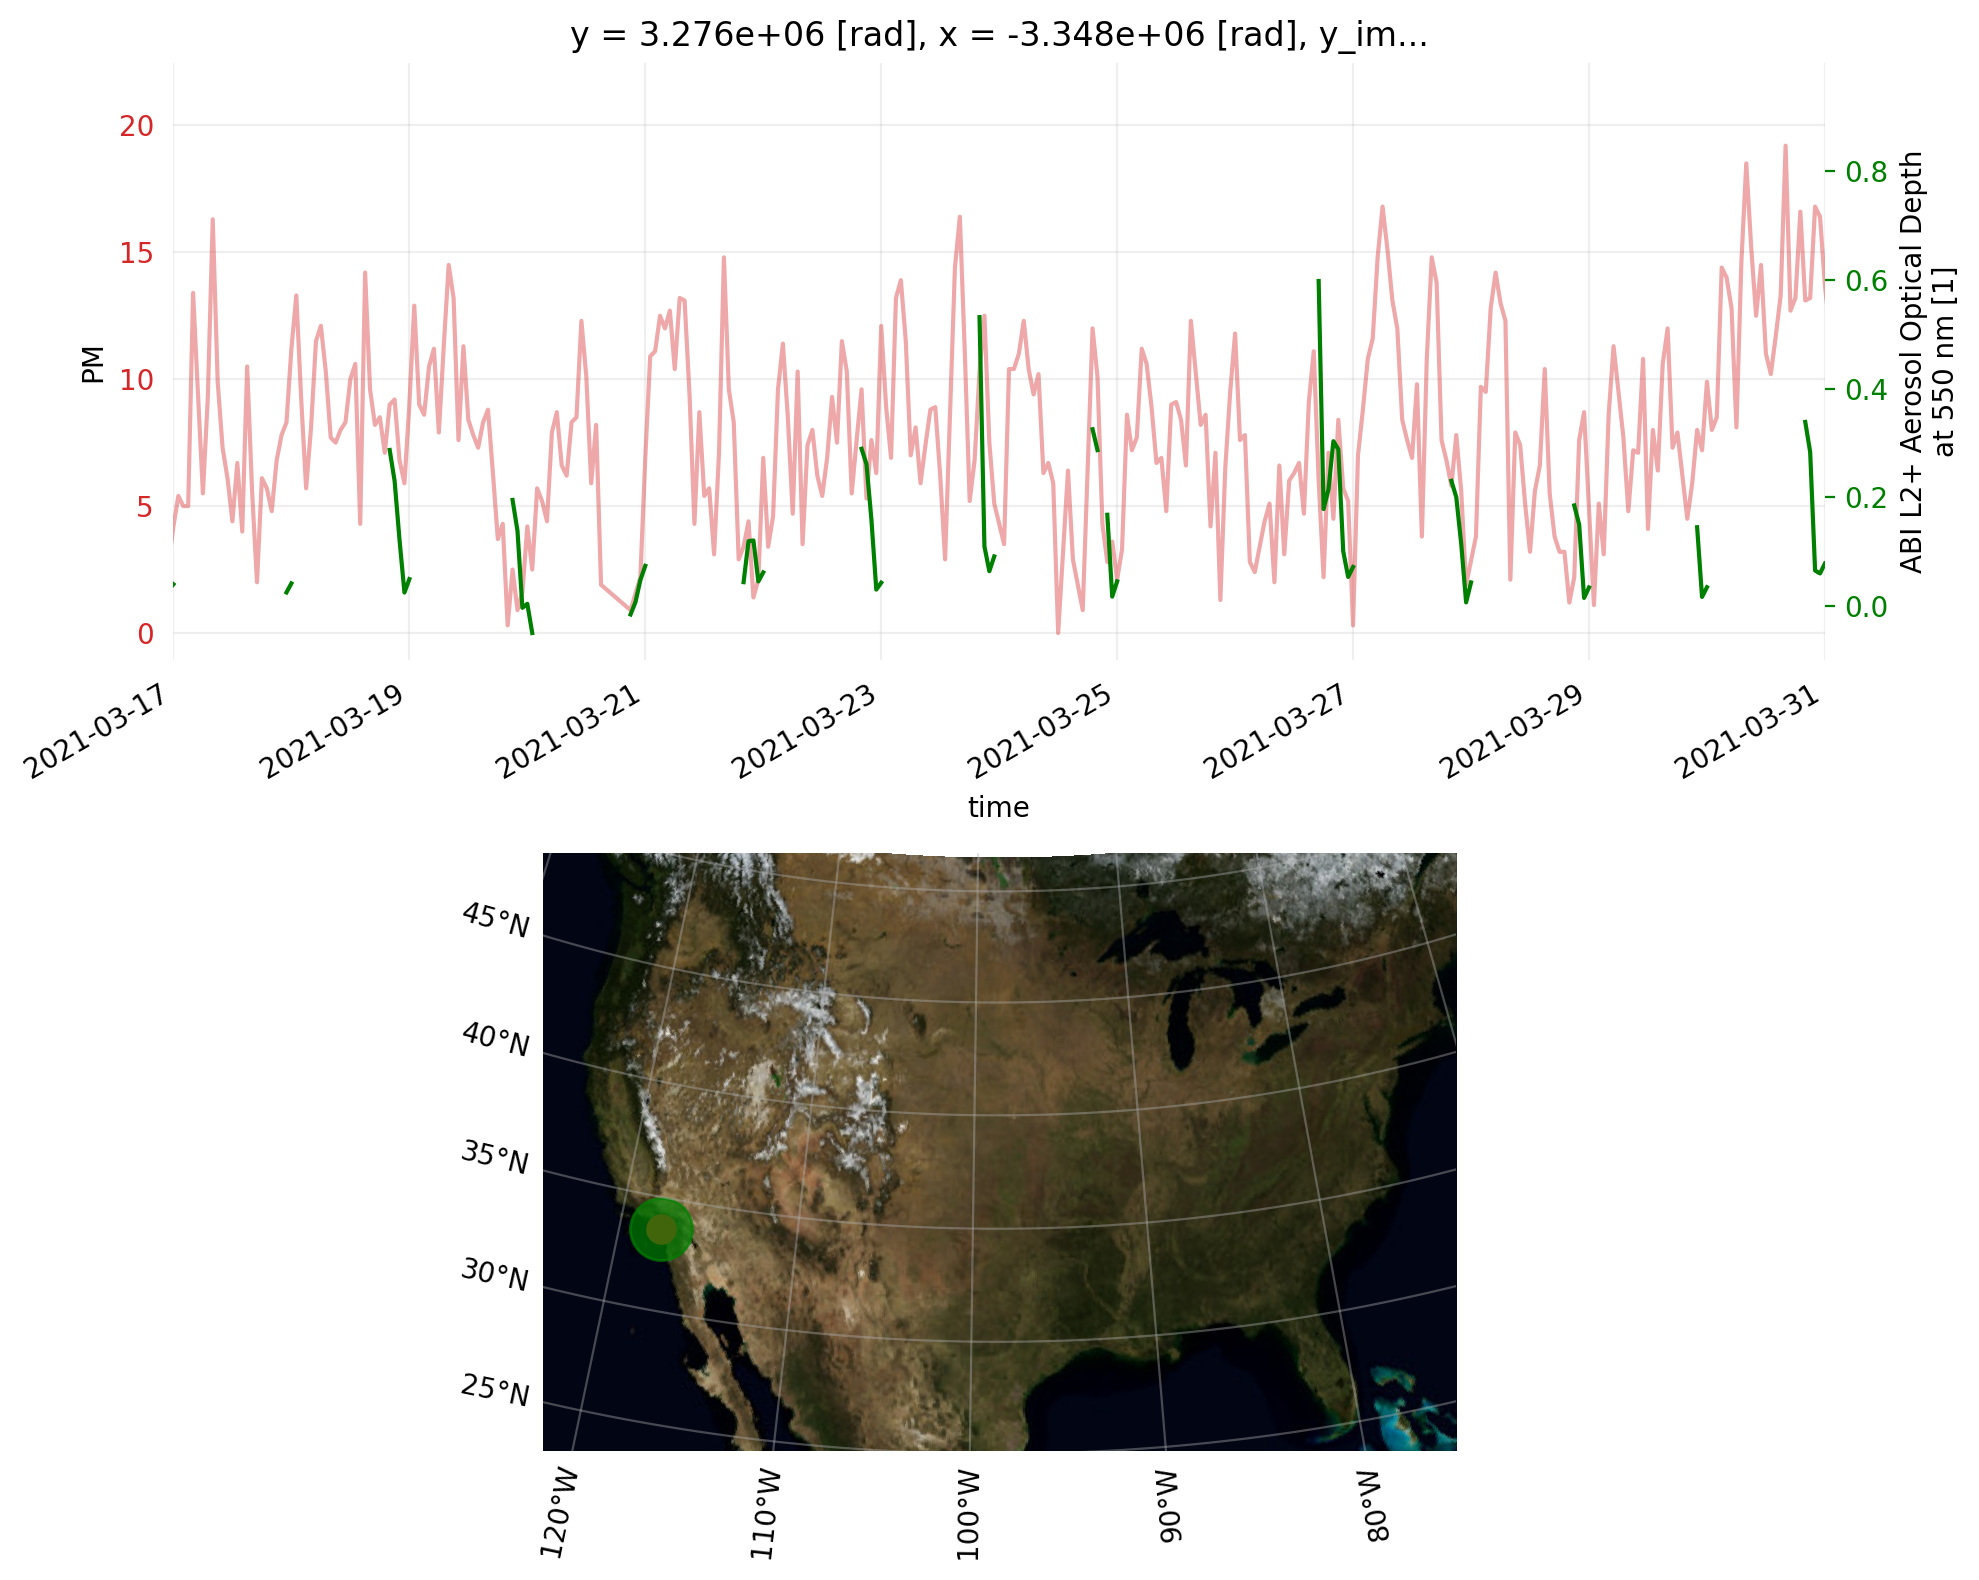

In [196]:
import datetime
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10,8), dpi=200)

ax1 = fig.add_subplot(211)
ax3 = fig.add_subplot(212, projection=equal_area)

b = adf.set_index('time').loc['2021-03-01':'2021-03-31'].reset_index()
b.plot(x='time', y='value', ax=ax1, alpha=0.4, legend=False, color='tab:red')
ax1.set_ylabel('PM')

ax2 = ax1.twinx()

ds.sel(x=x, y=y, method='nearest').AOD.plot(ax=ax2, color='green')

ax1.set_xlim([datetime.date(2021, 3, 31-14), datetime.date(2021, 3, 31)])

ax1.tick_params(axis='y', colors='tab:red')
ax2.tick_params(axis='y', colors='green')

ax1.tick_params(width=0)
ax1.grid(alpha=0.2)
for spine in ['top', 'left', 'bottom', 'right']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

ax3.set_extent(
    (
        -122, 
        -75,
        25, 
        50,
    ), crs=plate)


nearest = ds.sel(x=x, y=y, method='nearest')

ax3.scatter(x, y, 
            transform=geo, 
            s=100, color='tab:red')
ax3.scatter(nearest.x.item(), nearest.y.item(),
            transform=geo, 
            s=500, color='green', alpha=0.7)

ax3.add_wms(wms='https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS',
               layers=['BlueMarbleNG'])
# ax3.add_feature(cfeature.STATES, edgecolor='white')

gl = ax3.gridlines(draw_labels=True, alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax3.spines['geo'].set_visible(False)

plt.tight_layout()

In [186]:
locations = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

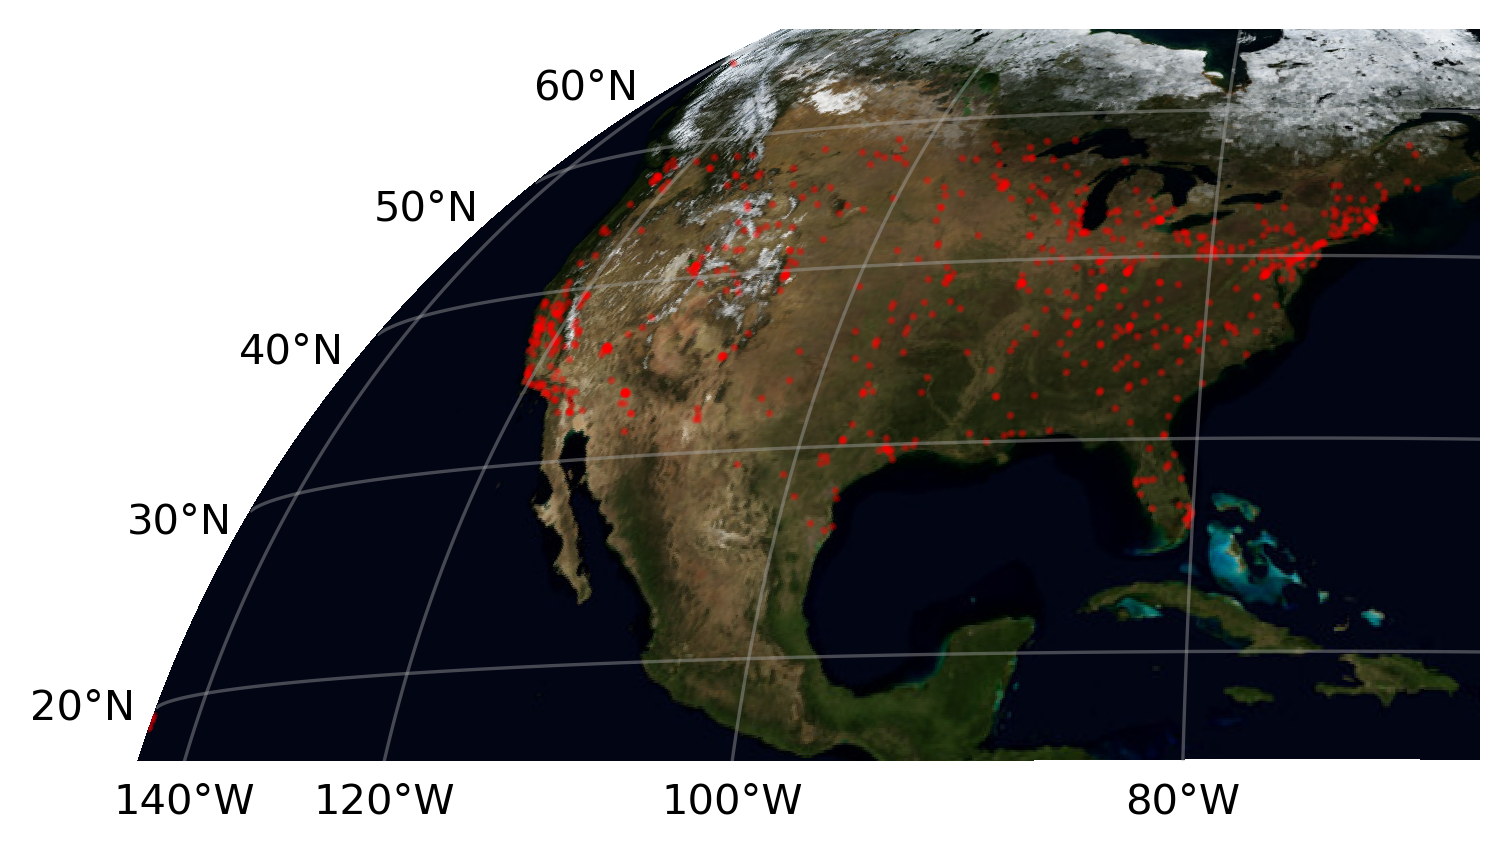

In [190]:
fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': geo})

ax.scatter(locations.longitude, locations.latitude, 
           s=1, 
           alpha=0.3, 
           color='red', 
           transform=plate)

# https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS&request=GetCapabilities
ax.add_wms(wms='https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS',
               layers=['BlueMarbleNG'])

gl = ax.gridlines(draw_labels=True, alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax.spines['geo'].set_visible(False)

In [102]:
unique, counts = np.unique(df.value.values, return_counts=True)

In [103]:
value_counts = pd.DataFrame({'values': unique, 'count': counts})

In [133]:
non_integers = value_counts[value_counts['values'] % 1 != 0]
integers = value_counts[value_counts['values'] % 1 == 0]

In [141]:
integers['count'].sum(), non_integers['count'].sum()

(2769004, 3289790)

In [144]:
stats = df.describe()

In [156]:
stats

latitude     longitude         value
count  6.058794e+06  6.058794e+06  6.058794e+06
mean   3.844379e+01 -9.625235e+01  8.902786e+00
std    5.489623e+00  1.829204e+01  9.420297e+00
min    1.911756e+01 -1.593662e+02  0.000000e+00
25%    3.545011e+01 -1.120131e+02  4.100000e+00
50%    3.912886e+01 -9.117922e+01  7.000000e+00
75%    4.172689e+01 -8.163398e+01  1.100000e+01
max    6.153416e+01 -6.801619e+01  8.360000e+02

4337791


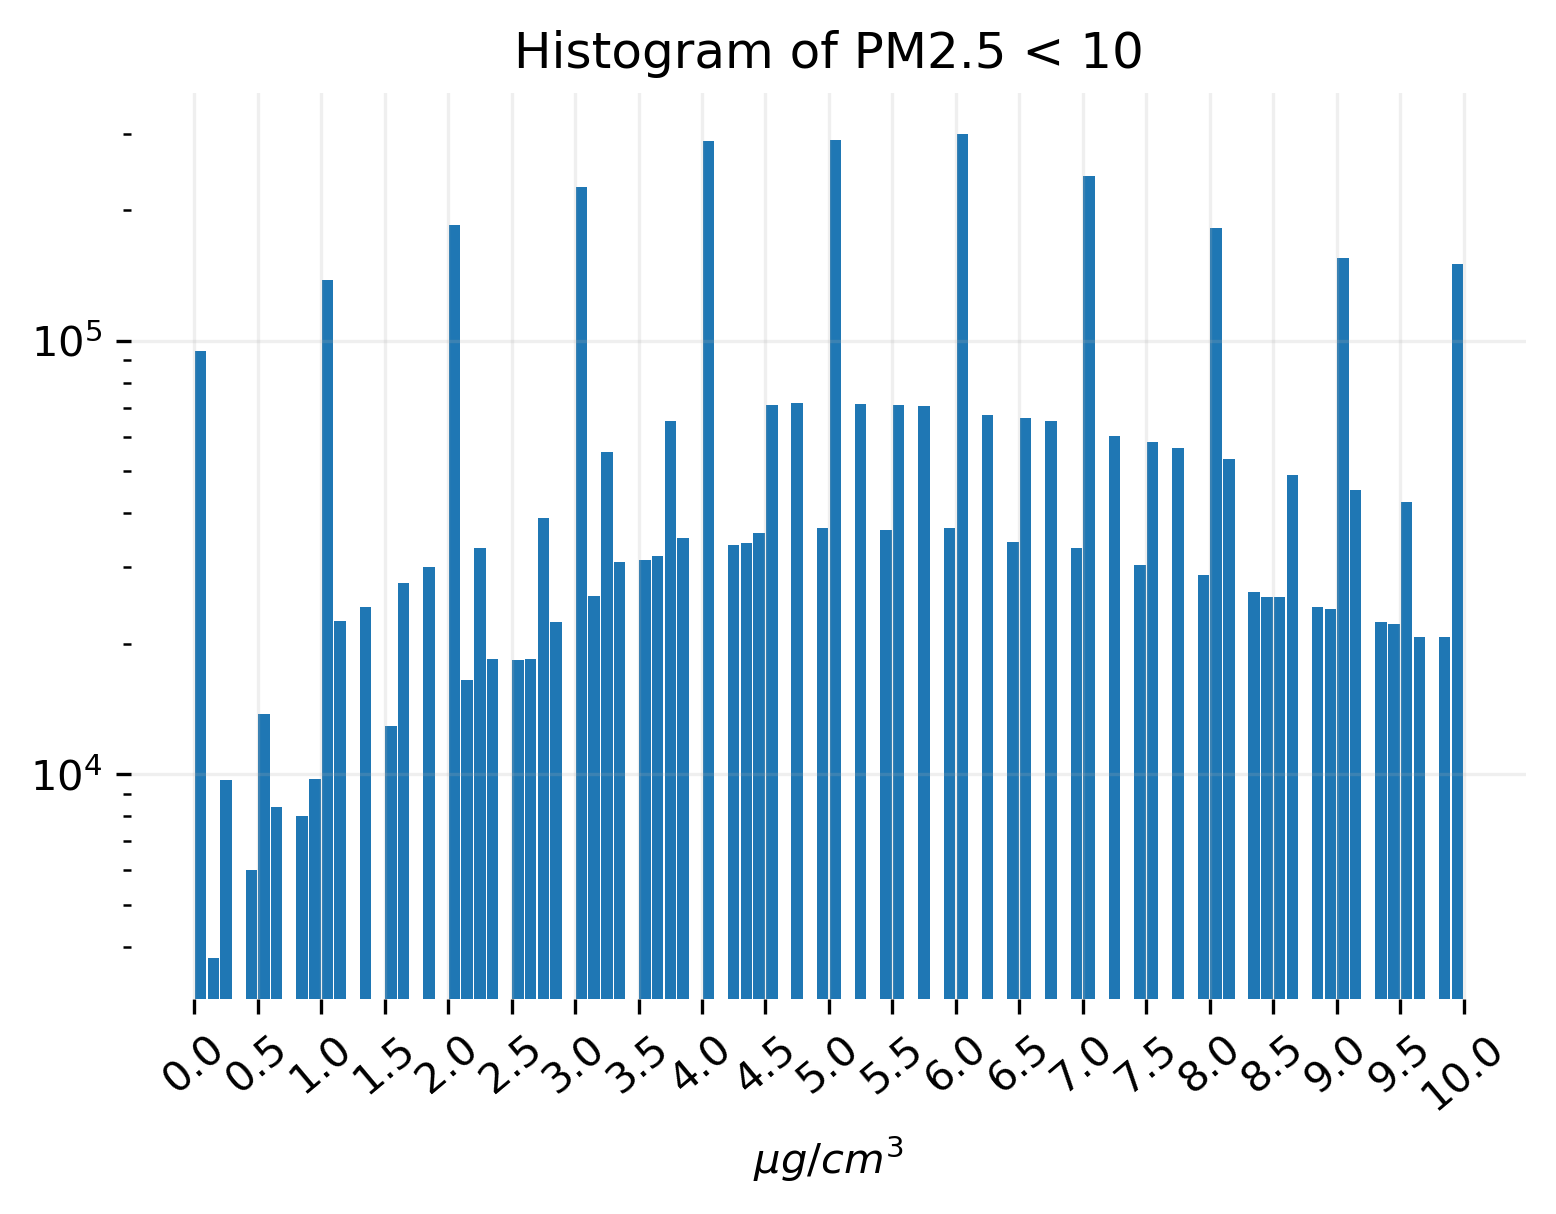

In [174]:
fig, ax = plt.subplots(dpi=300)

# df.value.hist(rwidth=0.8, bins=unique.shape[0], ax=ax)
# vals = df.value[df.value < np.percentile(unique, 80)]

mx = 10

vals = df.value[df.value <= mx]
print(vals.shape[0])
vals.hist(bins=100, rwidth=0.9, ax=ax)

step = 0.5
ax.set_xticks(np.arange(0, mx + 1 - step, step))

ax.set_yscale('log')
ax.set_xlabel('$µg/cm^3$')
ax.grid(alpha=0.2)

ax.set_title(f'Histogram of PM2.5 < {mx}')

ax.tick_params(axis='x', rotation=40)
for spine in ['top', 'left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)

# Old Version of matching

In [147]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for k, vs in files.items():
    ds = xr.open_mfdataset(
        vs,
        concat_dim="t", 
        parallel=True, 
        combine='nested',
        data_vars='different',
    ).compute()
    sat_h = ds.goes_imager_projection.perspective_point_height
    ds = ds.assign_coords(x=ds.x*sat_h, y = ds.y*sat_h)
    
    start, end = map(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d %H:%M:%S'), ds.t[[0, -1]].values)
    sub = df.loc[start:end]
    for (time, lat, lon), row in sub.iterrows():
        time = pd.to_datetime(time).strftime('%Y-%m-%d %H:%M:%S')
        try:
            data = ds.sel(
                x=row.proj_longitude, 
                y=row.proj_latitude, 
                t=time,
                method='nearest', 
                tolerance=2000
            )
            if np.isfinite(data.AOD).any():
                df.loc[(time, lat, lon), 'AOD'] = data.AOD.item()
        except:
            pass

In [ ]:
df_aod = ds.drop_vars(['y_image',
     'x_image',
     'sunglint_angle',
     'retrieval_local_zenith_angle',
     'quantitative_local_zenith_angle',
     'retrieval_solar_zenith_angle',
     'quantitative_solar_zenith_angle',
     'aod_product_wavelength'])[['AOD']]\
        .to_dataframe().reset_index().dropna()

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

pbar = tqdm(files.items())
for k, vs in pbar:
    ds = xr.open_mfdataset(
        vs,
        concat_dim="t", 
        parallel=True, 
        combine='nested',
        data_vars='different',
    ).compute()
    sat_h = ds.goes_imager_projection.perspective_point_height
    ds = ds.assign_coords(x=ds.x*sat_h, y = ds.y*sat_h)
    for t in tqdm(ds.t, leave=False):
        tm = pd.to_datetime(t.item()).strftime('%Y-%m-%d %H:%M:%S')
        ds_t = ds.sel(t=t)
        if np.isfinite(ds_t.AOD).any():
            sub = df.loc[tm]
            for (lon, lat), row in sub.iterrows():
                data = ds_t.sel(
                    x=row.proj_longitude, 
                    y=row.proj_latitude, 
                    method='nearest', 
                    tolerance=1000
                )
                if np.isfinite(data.AOD).any():
                    df.loc[(tm, lon, lat), 'AOD'] = data.AOD.item()

# Probably useless graphs

In [11]:
n = 0
t = 0
for idx, adf in df.groupby(['time', 'longitude', 'latitude']):
    if adf.shape[0] > 1:
        n += 1
    t += 1

In [12]:
print(f'{t} total groups, {n} have more than one observation at one point in time')

5748901 total groups, 309893 have more than one observation at one point in time


In [56]:
spreads = []
for idx, adf in df.groupby(['time', 'longitude', 'latitude']):
    if adf.shape[0] > 1:
        spreads.append(adf.value.max() - adf.value.min())

In [68]:
spreads = np.array(spreads)

Text(0.5, 1.0, 'max(PM) - min(PM)')

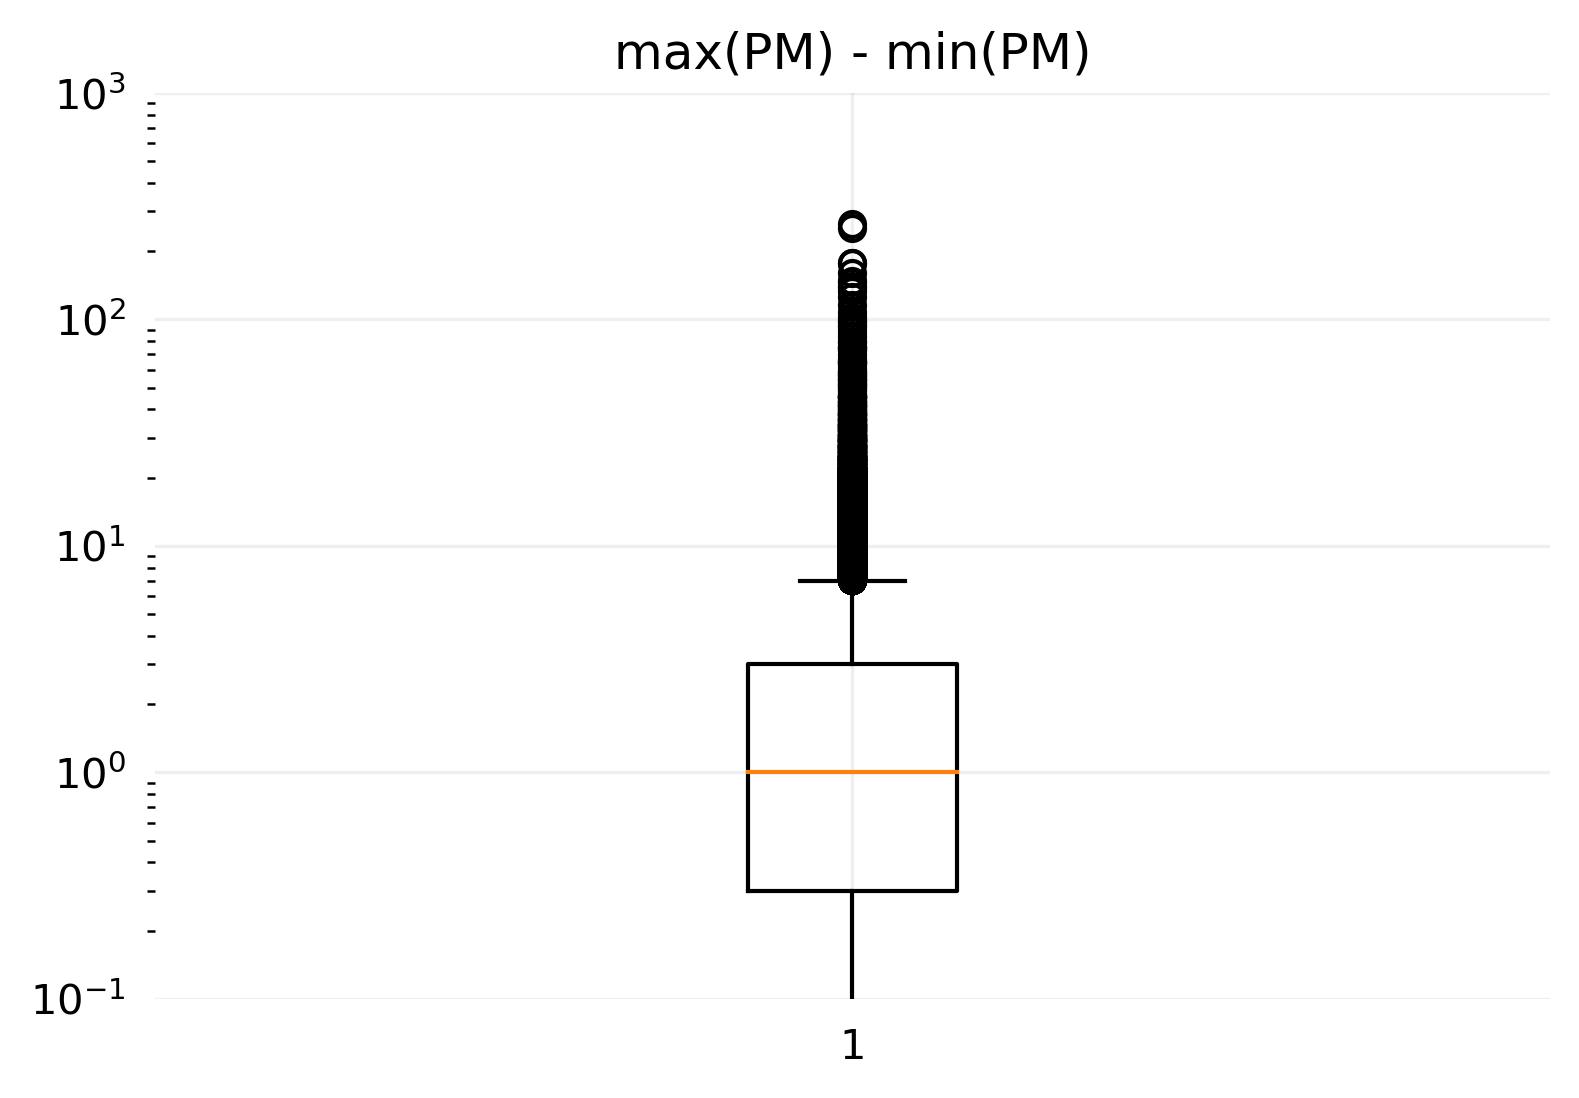

In [158]:
fig, ax = plt.subplots(dpi=300)

ax.boxplot(spreads)

# q1 = np.percentile(spreads, 25, interpolation='midpoint')
# q3 = np.percentile(spreads, 75, interpolation='midpoint')
# iqr = q3-q1

# ax.axhline(q3 + 1.5 * iqr)

ax.grid(alpha=0.2)
ax.tick_params(width=0)

ax.set_yscale('log')
ax.set_ylim((0.1,1000))

for spine in ['top', 'left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('max(PM) - min(PM)')